In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [ ]:
%%writefile content.json

{ "intents":
  [
    {
      "tag":"greeting",
      "input": ["hai", "halooo", "selamat pagi", "heyyy", "alo", "pagi", "weee", "aku mau tanya"],
      "responses":[
         "Halo, ada yang bisa saya bantu",
         "Halloo, teman Tel-Hub",
         "Hai, teman Tel-Hub",
         "Hai! Bagaimana saya dapat membantu Anda hari ini?",
         "Halo juga! Ada yang bisa saya bantu?",
         "Heyyy! Apa kabar? Ada yang ingin Anda bicarakan?"
        ]
    },
    {
      "tag":"jointalent",
      "input": [
                "Bagaimana cara jadi talent disini?",
               "Gimana cara jadi talent?",
               "Apa yang harus dilakuin klo mau jadi talent?",
               "Gimana cara gabung jadi talent?",
               "Gue mau jadi talent, gimana cara joinnya?",
               "Saya tertarik menjadi talent, bagaimana proses bergabungnya?",
               "Bagaimana langkahnya untuk menjadi talent di sini?",
               "Gimana caranya jadi talent?",
               "Apa langkah yang perlu diambil jika ingin menjadi talent?"],
      "responses":[
          "Untuk menjadi talent kami, kamu bisa daftar melalui aplikasi Talent-Hub fot Talent",
          "Kunjungi aplikasi Talent-Hub for Talent untuk menjadi talent kami",
          "Jikan ingin menjadi talent kamu bisa mengunungi aplikasi Talent-Hub for Talent"
        ]
    },
    {
      "tag":"biayajaditalent",
      "input": ["Kalau jadi talent bayar ya?",
                "Apakah ada biaya untuk jadi talent?",
                "Berapa uang yang dikeluarkan jika ingin jadi talent?",
                "Apakah ada biaya yang harus dibayarkan jika saya menjadi talent?",
                "Jika saya ingin menjadi talent, apakah ada biaya yang harus saya keluarkan?",
                "Adakah biaya yang terkait dengan menjadi talent di sini?"],
      "responses":[
        "Untuk saat ini, kamu tidak memungut biaya apapun untuk menjadi talent. Jadi kamu bisa menjadi talent secara gratis di aplikasi kami",
        "Tidak, kami tidak memungut biaya apapun", "Saat ini, tidak ada biaya yang dikenakan untuk menjadi talent. Jadi, Anda dapat bergabung sebagai talent secara gratis di aplikasi kami.",
        "Tidak, tidak ada biaya yang harus dibayar sama sekali.",
        "Anda tidak perlu membayar apa pun untuk menjadi talent di sini. Pendaftaran dan bergabungnya adalah gratis.",
        "Kami menawarkan layanan pendaftaran sebagai talent tanpa biaya. Jadi, Anda dapat menjadi talent tanpa membayar.",
        "Untuk saat ini, menjadi talent di aplikasi kami sepenuhnya gratis, tanpa biaya pendaftaran atau biaya lainnya."
        ]
    },
    {
      "tag":"syarattalent",
      "input": ["Apa saja syarat untuk mendaftar menjadi talent?",
                "Syarat jadi talent apa?",
                "Apa saja yang dibutuhkan untuk menjadi talent di sini?",
                "Jelaskan syarat-syarat pendaftaran sebagai talent.",
                "Jika saya ingin menjadi talent, apa saja persyaratan yang perlu saya penuhi?",
                "Berbicara mengenai pendaftaran sebagai talent, apa saja yang harus saya persiapkan?"],
      "responses":[
          "Kamu bisa membuka aplikasi Talent-Hub for Talent yang sudah diunduh dan klik register lalu ikuti arahan yang tertera di sana",
          "Cukup masukkan data diri yang diminta dan foto yang valid kemudian tunggu admin memvalidasi akun kamu!",
          "Buka aplikasi Talent-Hub yang telah diunduh, lalu pilih opsi pendaftaran dan ikuti petunjuk yang ada di layar",
          "Daftarkan diri di aplikasi Talent-Hub dengan mengisi data pribadi yang diminta dan mengunggah foto yang valid. Setelah itu, tunggu proses validasi oleh admin!",
          "Jika sudah mengunduh aplikasi Talent-Hub, silakan buka dan lakukan pendaftaran. Ikuti instruksi yang diberikan saat pendaftaran dan unggah foto valid. Selanjutnya, tunggu akun Anda divalidasi oleh admin.",
          "Untuk mendaftar sebagai talent, cukup isi data diri yang diminta dan sertakan foto yang valid di aplikasi Talent-Hub. Pastikan untuk mengikuti panduan yang muncul di layar, dan tunggu sampai admin memvalidasi akun Anda!"
        ]
    },
   {
      "tag":"benefittalent",
      "input": ["Keuntungan jadi talent apa?",
                "Kalau aku jadi talent, keuntungan apa yang aku dapatkan?",
                "Apa yang aku dapetin kalau jadi talent?",
                "Apa manfaatnya menjadi talent di sini?",
                "Jika saya menjadi talent, apa keuntungan yang bisa saya dapatkan?",
                "Bagaimana saya akan diuntungkan jika menjadi talent di sini?",
                "Apa yang dapat saya peroleh sebagai keuntungan jika saya bergabung sebagai talent?",
                "Bagaimana keuntungan yang bisa saya dapatkan jika saya menjadi talent di platform ini?"],
      "responses":[
          "Tentunya kamu akan bisa menjangkau customer lebih banyak karena aplikasi ini dikhususkan untuk para talent-talent",
          "Jika kamu tergabung dalam akun talent pro, kamu akan mendapatkan analisi akun kamu",
           "Anda tentu dapat mencapai lebih banyak pelanggan karena aplikasi ini dirancang khusus untuk para talent.",
           "Dengan bergabung dalam akun talent pro, Anda akan mendapatkan analisis untuk akun Anda.",
           "Keunggulan Anda sebagai talent akan terlihat dari kemampuan untuk menjangkau lebih banyak pelanggan melalui aplikasi yang fokus pada talent-talent.",
           "Jika Anda memilih untuk bergabung dalam akun talent pro, Anda akan mendapatkan wawasan yang berharga melalui analisis akun yang disediakan.",
           "Jika Anda menjadi bagian dari akun talent pro, Anda akan memperoleh analisis yang berguna untuk perkembangan akun Anda."

        ]
    },

     {
      "tag":"akusiapa",
      "input": ["Kamu siapa?", "Aku bisa panggil kamu apa?", "Kamu chatbot ya?", "Bagaimana saya sebaiknya menyebutmu?", "Boleh tahu siapa dirimu?", "Apa nama yang bisa saya gunakan untuk memanggilmu?"],
      "responses":[
              "Halo, saya Tata yang akan membantu kamu",
              "Saya bisa dipanggil Tata",
              "Iya benar saya chatbot yang bisa membantu anda",
              "Selamat datang, saya Tata, siap sedia membantu Anda.",
              "Saya dapat dipanggil Tata, dan saya di sini untuk membantu Anda.",
              "Halo, Tata di sini untuk memberikan bantuan.",
              "Anda boleh memanggil saya Tata, saya di sini untuk membantu."
        ]
    },

    {
      "tag":"goodbye",
      "input": ["Oke makasi", "Bye", "Daa", "Baik, terima kasih.","Selamat tinggal.","Sampai jumpa."],
      "responses":[
              "Terimakasih kembali", "Baik, sama-sama", "Semoga harimu menyenangkan", "Sama-sama, terima kasih juga.", "Semoga hari Anda menyenangkan juga."
        ]
    },

     {
      "tag":"jenistalent",
      "input": ["siapa saja yang bisa daftar menjadi talent", "talent apa saja yang bisa mendaftar?", "jenis talent apa saja yang bisa mendaftar?", "Apakah semua orang dapat mendaftar sebagai talent di sini?", "Siapa saja yang berhak mendaftar sebagai talent?", "Apa jenis talent yang diperbolehkan untuk mendaftar?", "Apakah ada batasan jenis talent yang dapat mendaftar?"],
      "responses":[
              "Untuk saat ini, kami hanya menerima talent di bidang musik. Kami akan memproses kategori lain segera. Mohon ditunggu",
              "Saat ini, pendaftaran talent hanya dibuka untuk kategori musik. Kami akan segera memproses kategori lainnya. Harap bersabar.",
              "Hanya talent di bidang musik yang dapat mendaftar untuk saat ini. Proses untuk kategori lain akan segera dilakukan. Silakan ditunggu.",
              "Kami sedang fokus menerima talent di bidang musik. Pemrosesan untuk kategori lain akan segera dimulai. Harap bersiap untuk informasi lebih lanjut.",
              "Kami saat ini hanya menerima pendaftaran talent di bidang musik. Kategori lain akan segera diakomodasi. Harap ditunggu.",
              "Hanya talent musik yang dapat mendaftar pada tahap ini. Kami akan segera memperluas ke kategori lainnya. Harap bersiap untuk informasi lebih lanjut."
        ]
    },

{
      "tag":"jadwaltalent",
      "input": ["Disini aku bisa liat jadwal talent nya nggk?", "Apakah aku bisa liat jadwal talent?", "Apakah di sini saya bisa melihat jadwal para talent?", "Dapatkah saya melihat jadwal para talent di platform ini?", "Bagaimana cara melihat jadwal para talent di sini?", "Bisakah saya mengakses jadwal para talent di sini?", "Bagaimana cara akses jadwal talent di platform ini?"],
      "responses":[
        "Mohon maaf untuk fitur jadwal, kami belum bisa menyediakannya. Segera akan kami proses untuk fitur ini",
        "Belum bisa. Namun akan kami bangun segera untuk fitu tersebut. Mohon ditunggu",
        "Kami meminta maaf, saat ini kami belum menyediakan fitur jadwal. Kami sedang dalam proses pengembangan untuk memperbarui fitur ini.",
        "Mohon maaf, kami masih bekerja pada pengembangan fitur jadwal. Kami akan memberitahu Anda segera setelah fitur tersebut tersedia.",
        "Saat ini, fitur jadwal belum dapat diakses. Kami berencana untuk segera mengimplementasikannya, mohon ditunggu.",
        "Mohon maaf, kami belum dapat menyediakan fitur jadwal saat ini. Akan segera kami perbarui untuk memberikan fitur tersebut.",
        "Untuk fitur jadwal, kami masih dalam tahap pengembangan. Kami akan memberitahu Anda begitu fitur tersebut telah tersedia."
        ]
    },

    {
      "tag":"booktalent",
      "input": ["Gimana cara book talent?", "Bagaimana cara booking talentnya?", "Bagaimana langkah untuk memesan talent?", "Bagaimana langkah untuk memesan talent?", "Bagaimana langkah untuk memesan talent?"],
      "responses":[
       "Caranya kalian bisa hubungi langsung kontak yang sudha tertera pada laman talent kalian ya",
       "Bisa hubungi kontak talent yang sudah tersedia",
        "Kamu bisa menghubungi kontak talent pada halaman talent ya"
        ]
    },

    {
      "tag":"benefittalentpro",
      "input": ["Kalau aku jadi telant pro, dapat apa ya kak?", "Keuntungan jadi talent pro apa ya?", "Kalau aku memutuskan untuk menjadi talent pro, apa yang akan aku dapatkan?", "Apa saja keuntungan yang mungkin aku dapatkan jika aku menjadi talent pro?"],
      "responses":[
          "Kamu tentu akan mendapatkan kesempatan untuk melihat analisis akun talent kamu",
          "Pastinya, kamu akan memiliki peluang untuk meninjau analisis akun talentmu."
        ]
    },


      {
      "tag":"fotounvalid",
      "input": ["kenapa foto saya dinyatakan unvalid?", "foto yang valid seperti apa?", "Mengapa gambar yang saya unggah dianggap tidak valid?", "Seperti apa gambar yang dianggap valid?" , "Bagaimana seharusnya gambar yang dianggap sah terlihat?"],
      "responses":[
         "Foto kamu dinyatakan unvalid karena tidak sesuai dengan ketentuan", "Pastikan foto kamu memperlihatkan wajah yang jelas tanpa terhalangi aksesoris apa pun", "Pastikan wajahmu terlihat di kamera"
        ]
    },

          {
      "tag":"biayatalentpro",
      "input": ["Biaya jadi talent pro berapa ya kak?", "Tarif jadi akun talent pro berapa kak?", "Kalau mau akun talent pro harus bayar berapa?", "Kak, berapa biaya yang dibutuhkan jika ingin menjadi talent pro?", "Berapa biaya yang harus dibayar untuk mendapatkan status talent pro, kak?", "Kak, bisa infokan tarif untuk mendapatkan akun talent pro?", "Bagaimana dengan biaya untuk menjadi talent pro, kak? Berapa ya?"],
      "responses":[
        "Untuk menjadi talent pro kamu cukup membayar sebasar 50k tiap bulannya", "Tarif untuk menjadi talent pro yakni 50k per bulannya kak", "Akun talent pro dikenai tarif sebesar 50k"
        ]
    },

    {
      "tag":"usiatalent",
      "input": ["Ada batasan usia untuk bisa jadi talent?", "Anak dibawah umur bisa jadi talent kah?"],
      "responses":[
       "Tidak, kami tidak menggunakan batasan umur", "Siapa saja berhak untuk mendafatar akun talent kami"
        ]
    },

    {
      "tag":"durasiprosesdaftar",
      "input": ["berapa lama proses pendaftaran talent?", "berapa waktu yang dibutuhkan untuk pendaftaran talent?", "berapa lama proses validasi akun?", "proses daftarnya lama gak?", "berapa lama waktu yang diperlukan untuk pendaftaran?"],
      "responses":[
       "Proses pendaftaran memerlukan waktu singkat. Admin akan segera memvalidasi pendaftaran Anda", "Proses pendaftaran dan validasi akun membutuhkan waktu 1x24 jam, mohon ditunggu.", "Admin akan memvalidasi akun Anda dalam waktu 1x24 jam, jika ada kendala silakan hubungi kontak admin", "Proses pendaftaran memerlukan waktu sebentar dan Admin akan segera memvalidasi pendaftaran Anda dalam 1x24 jam"
        ]
    }



  ]
}

Overwriting content.json


In [ ]:
with open ('content.json') as content:
  data_json = json.load(content)

# processing json data into dictionary

In [ ]:
tag=[]
inputt=[]
output={}
for intent in data_json['intents']:
  output[intent['tag']]=intent['responses']
  for lines in intent ['input']:
    inputt.append(lines)
    tag.append(intent['tag'])

# change the dictionary into dataframe

In [ ]:
df = pd.DataFrame({"inputs":inputt,
                     "tags":tag})

In [ ]:
df

,inputs,tags
0,hai,greeting
1,halooo,greeting
2,selamat pagi,greeting
3,heyyy,greeting
4,alo,greeting
...,...,...
86,berapa lama proses pendaftaran talent?,durasiprosesdaftar
87,berapa waktu yang dibutuhkan untuk pendaftaran...,durasiprosesdaftar
88,berapa lama proses validasi akun?,durasiprosesdaftar
89,proses daftarnya lama gak?,durasiprosesdaftar


# remove punctuation in corpusses

In [ ]:
import string
df['inputs'] = df['inputs'].apply(lambda word: [letter.lower() for letter in word if letter not in string.punctuation])
df['inputs'] = df['inputs'].apply(lambda word: ''.join(word))
df

,inputs,tags
0,hai,greeting
1,halooo,greeting
2,selamat pagi,greeting
3,heyyy,greeting
4,alo,greeting
...,...,...
86,berapa lama proses pendaftaran talent,durasiprosesdaftar
87,berapa waktu yang dibutuhkan untuk pendaftaran...,durasiprosesdaftar
88,berapa lama proses validasi akun,durasiprosesdaftar
89,proses daftarnya lama gak,durasiprosesdaftar


# preprocessing corpus into sequence with padding

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(df['inputs'])
train = tokenizer.texts_to_sequences (df['inputs'])


from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(df['tags'])



In [ ]:
input_shape = x_train.shape[1]
print (input_shape)

13


# calculating how many vocabulary and output length of one sequence created

In [ ]:
vocabulary = len(tokenizer.word_index)
print ("number of unique words: ", vocabulary)

output_length = le.classes_.shape[0]
print ("output lenght: ", output_length)

number of unique words:  157
output lenght:  15


# creating model

In [ ]:
inputs = tf.keras.layers.Input(shape=(input_shape))
x = tf.keras.layers.Embedding(vocabulary+1,10)(inputs)
x = tf.keras.layers.LSTM(10, return_sequences=True)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(output_length, activation="softmax")(x)

model = Model(inputs, x)

# compile model

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

# train the model

In [ ]:
train = model.fit(x_train, y_train, epochs=200)

Epoch 1/200
3/3 [==============================] - 2s 94ms/step - loss: 2.7081 - accuracy: 0.0440
Epoch 2/200
3/3 [==============================] - 0s 90ms/step - loss: 2.7047 - accuracy: 0.1319
Epoch 3/200
3/3 [==============================] - 0s 94ms/step - loss: 2.7016 - accuracy: 0.2198
Epoch 4/200
3/3 [==============================] - 0s 7ms/step - loss: 2.6986 - accuracy: 0.1758
Epoch 5/200
3/3 [==============================] - 0s 50ms/step - loss: 2.6952 - accuracy: 0.1429
Epoch 6/200
3/3 [==============================] - 0s 93ms/step - loss: 2.6914 - accuracy: 0.1209
Epoch 7/200
3/3 [==============================] - 0s 8ms/step - loss: 2.6878 - accuracy: 0.1099
Epoch 8/200
3/3 [==============================] - 0s 50ms/step - loss: 2.6834 - accuracy: 0.1209
Epoch 9/200
3/3 [==============================] - 0s 7ms/step - loss: 2.6786 - accuracy: 0.1209
Epoch 10/200
3/3 [==============================] - 0s 50ms/step - loss: 2.6729 - accuracy: 0.1209
Epoch 11/200
3/3 [====

# ploting the training acc and training loss per epoch

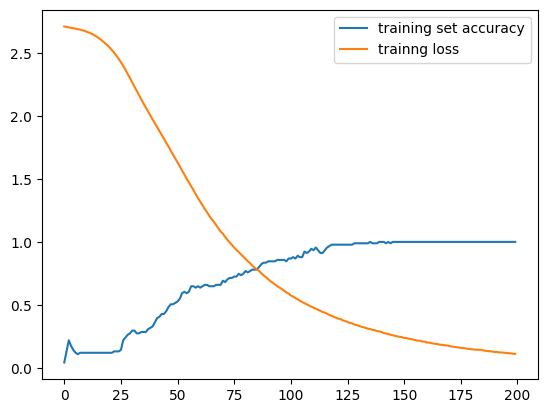

In [ ]:
plt.plot(train.history['accuracy'], label='training set accuracy')
plt.plot(train.history['loss'], label='trainng loss')
plt.legend()

# simulating prediction

In [ ]:
import random

texts = []
predict = "halo"

predict = [letter.lower() for letter in predict if letter not in string.punctuation]
predict = ''.join (predict)
texts.append(predict)


predict = tokenizer.texts_to_sequences(texts)
predict = np.array(predict).reshape(-1)
predict = pad_sequences([predict], input_shape)

predict = model.predict(predict)
predict = predict.argmax()

output_tag = le.inverse_transform([predict])[0]
print("Mia: ", random.choice(output[output_tag]))